## Analysis of mutation prediction results

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot as up
from venn import generate_petal_labels

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join('results', 'univariate_fs', 'pancancer')

In [3]:
results_df = au.load_prediction_results_fs(results_dir, cfg.fs_methods)

# temporary, change later when all genes finish running
results_df = results_df[results_df.gene == 'TP53'].copy()

results_df.loc[
    (results_df.fs_method == 'mad') & (results_df.n_dims == 100),
    'fs_method'
] = 'mad_100'
results_df.loc[
    (results_df.fs_method == 'mad') & (results_df.n_dims == 1000),
    'fs_method'
] = 'mad_1000'

print(results_df.shape)
print(results_df.fs_method.unique())
print(results_df.n_dims.unique())
results_df.head()

(240, 10)
['median_f_test' 'mad_100' 'mad_1000' 'mad_f_test' 'pancan_f_test']
[ 100 1000]


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims
0,0.55681,0.53291,TP53,NaN,shuffled,42,train,0,median_f_test,100
1,0.49419,0.46362,TP53,NaN,shuffled,42,test,0,median_f_test,100
2,0.51169,0.48608,TP53,NaN,shuffled,42,cv,0,median_f_test,100
3,0.54038,0.50844,TP53,NaN,shuffled,42,train,1,median_f_test,100
4,0.52547,0.49144,TP53,NaN,shuffled,42,test,1,median_f_test,100


In [4]:
compare_df = []
for fs_method in results_df.fs_method.unique():
    print(fs_method, file=sys.stderr)
    compare_df.append(
        au.compare_control_ind(results_df[results_df.fs_method == fs_method],
                               metric='aupr', verbose=True)
          .assign(fs_method=fs_method)
    )
compare_df = pd.concat(compare_df)

print(compare_df.shape)
compare_df.head()

(40, 5)


median_f_test
mad_100
mad_1000
mad_f_test
pancan_f_test


,identifier,seed,fold,delta_aupr,fs_method
0,TP53,42,0,0.38053,median_f_test
1,TP53,42,1,0.36588,median_f_test
2,TP53,42,2,0.40707,median_f_test
3,TP53,42,3,0.38879,median_f_test
4,TP53,1,0,0.37406,median_f_test


(0.0, 1.0)

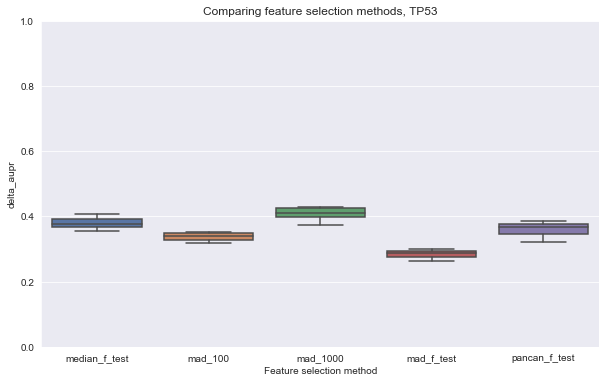

In [5]:
sns.set({'figure.figsize': (10, 6)})

sns.boxplot(data=compare_df, x='fs_method', y='delta_aupr')
plt.title('Comparing feature selection methods, {}'.format('TP53'))
plt.xlabel('Feature selection method')
plt.ylim(0, 1)

In [6]:
# analysis of selected features:
# overlap of features in at least one model
# f-statistic distributions for features in at least one model
# f-statistic distributions per fold
id_coefs_info = []
for identifier, coefs_list in au.generate_nonzero_coefficients_fs(
        results_dir, cfg.fs_methods):
    if not identifier.startswith('TP53'): continue
    for fold_no, coefs in enumerate(coefs_list):
        id_coefs_info.append([identifier, fold_no, coefs])
        
print(len(id_coefs_info))

40


In [7]:
print(len(id_coefs_info[0]))
print(id_coefs_info[0])

3
['TP53_mad_n100', 0, [('6490', -48.839), ('CESC', -10.332), ('OV', 4.6879), ('UCS', 2.6518), ('PAAD', 1.6652), ('BLCA', -1.21), ('log10_mut', 1.0676), ('LUAD', -0.8744), ('READ', 0.80921), ('HNSC', -0.78588), ('2023', 0.64835), ('6122', -0.53176), ('4627', 0.47179), ('64065', 0.43956999999999996), ('UCEC', -0.41885), ('3728', 0.39264), ('6222', 0.3911), ('12', -0.36707), ('ESCA', 0.36680999999999997), ('2752', -0.34245), ('2670', 0.33713000000000004), ('STAD', -0.33566999999999997), ('1191', -0.32795), ('63827', 0.3183), ('1938', -0.31626), ('6678', -0.3053), ('1278', 0.27712), ('3854', -0.26961999999999997), ('1832', -0.26254), ('629', -0.23788), ('26986', 0.23656), ('7178', -0.23283), ('348', 0.23258), ('335', -0.21043), ('3817', -0.2092), ('6439', -0.20898000000000003), ('2810', -0.2076), ('6132', 0.20713), ('5660', 0.2039), ('2597', -0.18273), ('3106', 0.17174), ('7431', -0.16660999999999998), ('100133941', 0.15582000000000001), ('972', -0.1554), ('3105', 0.14943), ('79026', -0.1

In [8]:
# list of sets, one for each feature selection method, of
# features that were selected in at least one cross-validation fold
fs_method_coefs = {}
for coefs_list in id_coefs_info:
    identifier = coefs_list[0]
    features = list(zip(*coefs_list[2]))[0]
    if identifier in fs_method_coefs:
        fs_method_coefs[identifier].update(features)
    else:
        fs_method_coefs[identifier] = set(features)
    
print(list(fs_method_coefs.keys()))

['TP53_mad_n100', 'TP53_mad_n1000', 'TP53_mad_f_test_n100', 'TP53_median_f_test_n100', 'TP53_pancan_f_test_n100']


In [9]:
print(len(fs_method_coefs['TP53_mad_n100']))
print(list(fs_method_coefs['TP53_mad_n100'])[:5])

118
['6176', '6175', '1281', '7431', '3488']


In [10]:
def series_from_samples(samples, labels):
    """Generate the weird dataframe format that Python upsetplot expects.
    
    Use as input lists of samples, and the labels that correspond
    to each list.
    """
    # use pyvenn to generate overlaps/labels from sample IDs
    venn_labels = generate_petal_labels(samples)
    # generate format upset plot package expects
    df_ix = [[(i == '1') for i in list(b)] + [int(v)] for b, v in venn_labels.items()]
    # generate dataframe from list
    rename_map = {ix: labels[ix] for ix in range(len(labels))}
    index_names = list(rename_map.values())
    rename_map[len(labels)] = 'id'
    df = (pd.DataFrame(df_ix)
        .rename(columns=rename_map)
        .set_index(index_names)
    )
    # and return as series
    return df['id']

In [11]:
upset_series = series_from_samples(
    list(fs_method_coefs.values()), list(fs_method_coefs.keys())
)
upset_series[upset_series != 0].sort_values(ascending=False).head(5)

TP53_mad_n100  TP53_mad_n1000  TP53_mad_f_test_n100  TP53_median_f_test_n100  TP53_pancan_f_test_n100
False          True            False                 False                    False                      498
                               True                  False                    False                      154
                               False                 True                     False                      147
                                                     False                    True                        64
True           True            False                 False                    False                       58
Name: id, dtype: int64

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

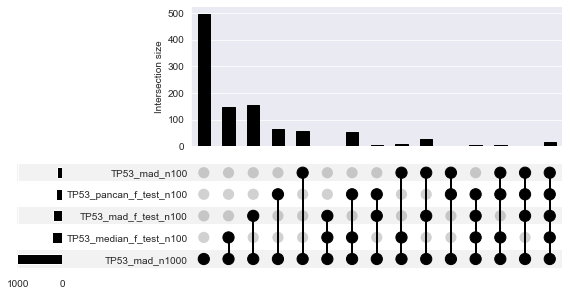

In [12]:
up.plot(upset_series[upset_series != 0])

In [13]:
fs_method_small = {
    k: v for k, v in fs_method_coefs.items() if 'mad_n1000' not in k
}
upset_series_small = series_from_samples(
    list(fs_method_small.values()), list(fs_method_small.keys())
)
upset_series_small[upset_series_small != 0].sort_values(ascending=False).head(5)

TP53_mad_n100  TP53_mad_f_test_n100  TP53_median_f_test_n100  TP53_pancan_f_test_n100
False          True                  False                    False                      154
               False                 True                     False                      147
                                     False                    True                        64
True           False                 False                    False                       58
False          False                 True                     True                        54
Name: id, dtype: int64

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

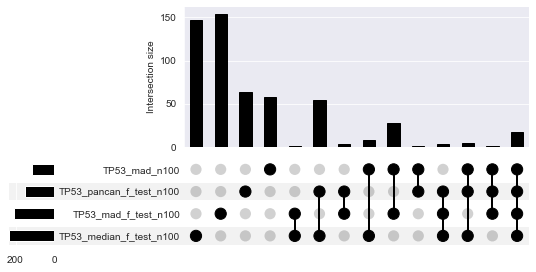

In [14]:
up.plot(upset_series_small[upset_series_small != 0])